In [288]:
import h5py
import pandas as pd
import numpy as np
from permetrics import RegressionMetric
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import statsmodels.api as sm

In [13]:
from abc import ABC, abstractmethod

class Metric(ABC):
    @abstractmethod
    def compute(self, y_true, y_pred):
        pass

    def masked_compute(self, y_true, y_pred):
        nan_mask = ~np.isnan(y_true)
        y_true = y_true[nan_mask]
        y_pred = y_pred[nan_mask]
        return self.compute(y_true, y_pred)

In [20]:
class PCC(Metric):
    def compute(self, y_true, y_pred):
        evaluator = RegressionMetric(y_true, y_pred)
        return evaluator.pearson_correlation_coefficient()
    
class MAE(Metric):
    def compute(self, y_true, y_pred):
        evaluator = RegressionMetric(y_true, y_pred)
        return evaluator.mean_absolute_error()

class MAAPE(Metric):
    def compute(self, y_true, y_pred):
        evaluator = RegressionMetric(y_true, y_pred)
        return evaluator.mean_arctangent_absolute_percentage_error()

In [21]:
metric_to_func = dict(
    PCC=PCC(),
    MAE=MAE(),
    MAAPE=MAAPE()
)

In [289]:
def compute_performance_metrics(exp_name, fpath):
    sample_perf = defaultdict(list)
    with h5py.File(fpath, 'r') as f:
        ctrl_pred = f['y_pred_ctrl'][:]
        depr_pred = f['y_pred_depr_diff'][:]
        cond_pred = f['y_pred_full'][:]

        ctrl_true = f['y_true_ctrl'][:]
        depr_true = f['y_true_dd'][:]
        cond_true = f['y_true_full'][:]

        conditions = f['condition'][:].astype('U')

        for sample_idx in range(ctrl_pred.shape[0]):
            condition = conditions[sample_idx]
            for m, f in metric_to_func.items():
                sample_perf[f"depr_{m}"].append(
                    None if condition == 'CTRL' else f.masked_compute(y_true=depr_true[sample_idx], y_pred=depr_pred[sample_idx]))
                sample_perf[f"ctrl_{m}"].append(
                    None if condition != 'CTRL' else f.masked_compute(y_true=ctrl_true[sample_idx], y_pred=ctrl_pred[sample_idx]))

            sample_perf["condition"].append(condition)
            sample_perf["n_codons"].append(len(depr_true[sample_idx]))

            sample_perf["depr_skew"].append(skew(depr_true[sample_idx], nan_policy="omit"))
            sample_perf["depr_kurtosis"].append(kurtosis(depr_true[sample_idx], nan_policy="omit"))
            sample_perf["depr_var"].append(np.nanvar(depr_true[sample_idx]))
            sample_perf["depr_std"].append(np.nanstd(depr_true[sample_idx]))
            sample_perf["depr_mean"].append(np.nanmean(np.abs(depr_true[sample_idx])))
            sample_perf["depr_max"].append(np.nanmax(depr_true[sample_idx]))

            sample_perf["ctrl_skew"].append(skew(ctrl_true[sample_idx], nan_policy="omit"))
            sample_perf["ctrl_kurtosis"].append(kurtosis(ctrl_true[sample_idx], nan_policy="omit"))
            sample_perf["ctrl_var"].append(np.nanvar(ctrl_true[sample_idx]))
            sample_perf["ctrl_std"].append(np.nanstd(ctrl_true[sample_idx]))
            sample_perf["ctrl_mean"].append(np.nanmean(ctrl_true[sample_idx]))

            sample_perf["cond_mean"].append(np.nanmean(cond_true[sample_idx]))

    return pd.DataFrame(sample_perf).assign(exp_name=exp_name)

In [290]:
data=pd.concat([
    compute_performance_metrics('4L', '/Users/craigher/switchdrive/Projects/ribotly/data/4L/attributions.h5'),
    compute_performance_metrics('5L', '/Users/craigher/switchdrive/Projects/ribotly/data/full_Test_LIG/attributions.h5'),
    compute_performance_metrics('3L', '/Users/craigher/switchdrive/Projects/ribotly/data/3L/attributions.h5')
])

/Users/craigher/micromamba/envs/plotting/lib/python3.12/site-packages/permetrics/regression.py:376: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.arctan(np.abs((y_true - y_pred) / y_true)), axis=0)
/Users/craigher/micromamba/envs/plotting/lib/python3.12/site-packages/permetrics/regression.py:376: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.arctan(np.abs((y_true - y_pred) / y_true)), axis=0)
/Users/craigher/micromamba/envs/plotting/lib/python3.12/site-packages/permetrics/regression.py:376: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.arctan(np.abs((y_true - y_pred) / y_true)), axis=0)
/Users/craigher/micromamba/envs/plotting/lib/python3.12/site-packages/permetrics/regression.py:376: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.arctan(np.abs((y_true - y_pred) / y_true)), axis=0)


Text(0.5, 1.0, 'MAAPE')

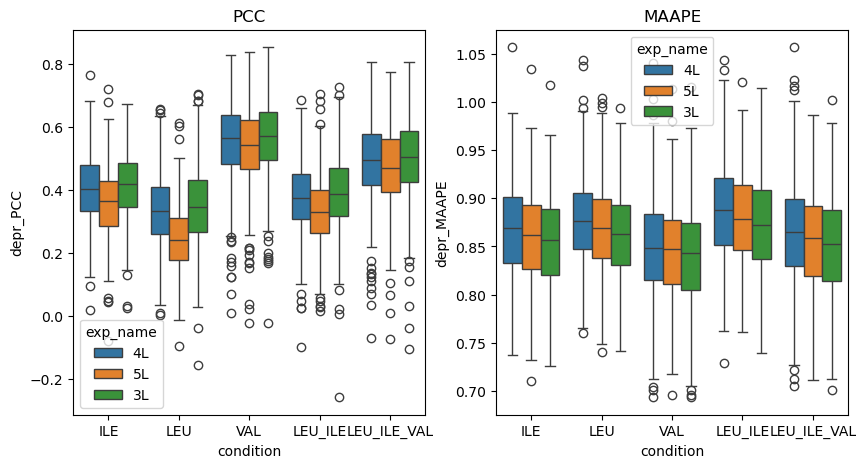

In [143]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(x='condition', y='depr_PCC', hue='exp_name', data=data.query('condition != "CTRL"'), ax=ax1)
ax1.set_title('PCC')

sns.boxplot(x='condition', y='depr_MAAPE', hue='exp_name', data=data.query('condition != "CTRL"'), ax=ax2)
ax2.set_title('MAAPE')

Text(0.5, 1.0, 'MAAPE')

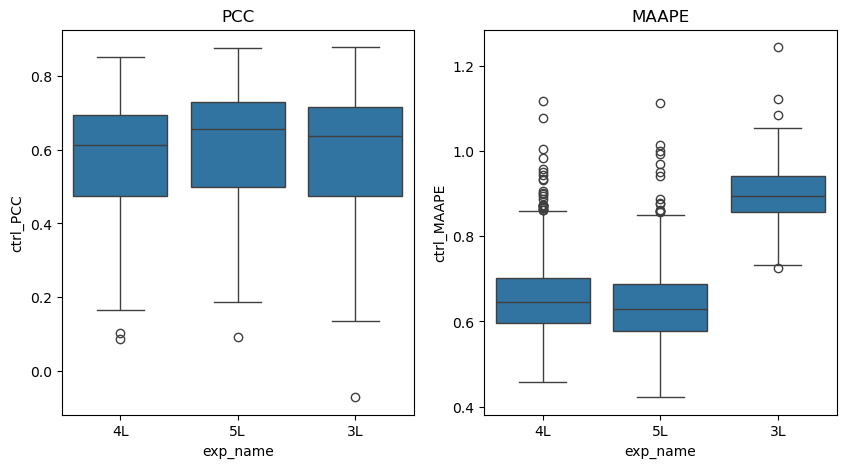

In [144]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(y='ctrl_PCC', x='exp_name', data=data.query('condition == "CTRL"'), ax=ax1)
ax1.set_title('PCC')

sns.boxplot(y='ctrl_MAAPE', x='exp_name', data=data.query('condition == "CTRL"'), ax=ax2)
ax2.set_title('MAAPE')

<Axes: xlabel='condition', ylabel='depr_kurtosis'>

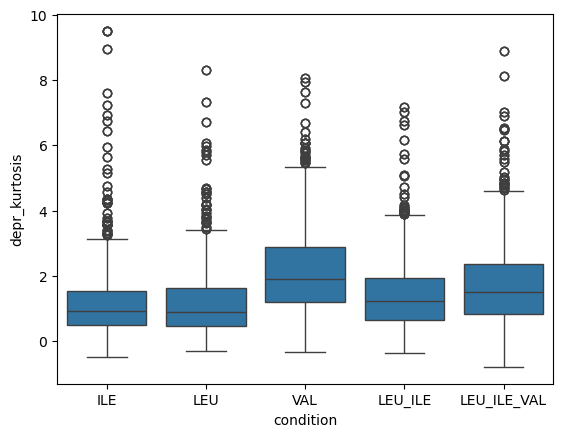

In [284]:
sns.boxplot(x='condition', y='depr_kurtosis', data=data.query('condition != "CTRL" and depr_kurtosis < 10'))

SignificanceResult(statistic=0.35695816078611, pvalue=1.2374983292737875e-96)


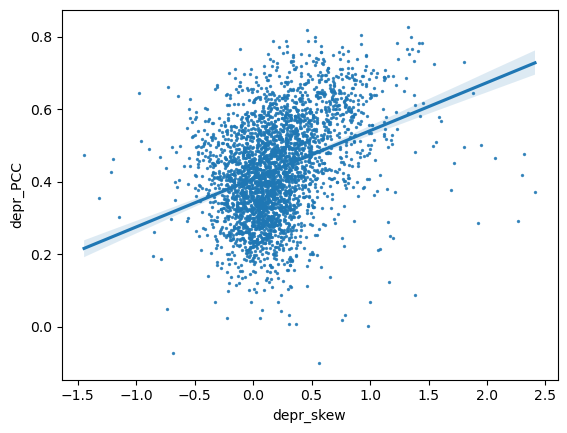

In [295]:
from scipy.stats import pearsonr

X=data.query('exp_name == "4L" and condition!="CTRL"')['depr_skew']
Y=data.query('exp_name == "4L" and condition!="CTRL"')['depr_PCC']
sns.regplot(x=X, y=Y,scatter_kws={'s':2})
print(spearmanr(X, Y))

In [293]:
# Define the dependent and independent variables
view = data.query('exp_name == "4L" and condition != "CTRL"')

Y = view['depr_PCC']
X = view[['cond_mean', 'depr_kurtosis', 'depr_mean']]

# Add a constant to the independent variables matrix (intercept)
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(Y, X).fit()

# Print out the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               depr_PCC   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     369.0
Date:                Wed, 07 Aug 2024   Prob (F-statistic):          1.03e-205
Time:                        15:59:09   Log-Likelihood:                 2251.1
No. Observations:                3195   AIC:                            -4494.
Df Residuals:                    3191   BIC:                            -4470.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1630      0.030     -5.403